In [6]:
"""
Classification of the Planet SuperDove imagery from the XGBoost model
Author: maxwell.cook@colorado.edu
"""

import os, time, sys
import xgboost as xgb

# Functions script import
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

print(os.getcwd())

# maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
homedir = '/home/jovyan/data-store/data/iplant/home/maco4303/data/' # cyverse

print("Imports successful!")

/home/jovyan/data-store/opp-rooftop-mapping/code
Imports successful!


In [7]:
# results_dir = os.path.join(maindir, 'results/xgboost-cv/classification/')
results_dir = os.path.join(homedir, 'OPP/results/xgboost-cv/classification/') # cyverse
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(f"Saving results to {results_dir}")

Saving results to /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/classification/


In [ ]:
# Load the reference footprint data

In [9]:
# ref_fp = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
ref_fp = os.path.join(homedir,'OPP/training/dc/dc_data_reference_footprints.gpkg')
ref = gpd.read_file(ref_fp)
n_classes = len(ref['class_code'].unique())
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,"POLYGON ((333608.130 4306267.691, 333607.957 4..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [10]:
# Create a dictionary mapping class_code to numeric code
ref['code'], _ = pd.factorize(ref['class_code'])
code_mapping = dict(zip(ref['class_code'], ref['code']))
desc_mapping = dict(zip(ref['class_code'], ref['description']))
print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{'CS': 0, 'ME': 1, 'SL': 2, 'UR': 3, 'TL': 4, 'WS': 5, 'SH': 6}
Description map: 
{'CS': 'Composition Shingle', 'ME': 'Metal', 'SL': 'Slate', 'UR': 'Urethane', 'TL': 'Tile', 'WS': 'Wood shake/shingle', 'SH': 'Shingle'}


In [ ]:
# Load the best XGBoost model from cross-validation based on holdout accuracy

In [11]:
best_fold = 4
best_params = {
    'learning_rate': 0.002185884764883822, 
    'max_depth': 12, 
    'n_estimators': 837, 
    'min_child_weight': 2, 
    'subsample': 0.5014281326674929, 
    'colsample_bytree': 0.9226235922462854, 
    'gamma': 0.8462080004717595
}
print(best_params)

{'learning_rate': 0.002185884764883822, 'max_depth': 12, 'n_estimators': 837, 'min_child_weight': 2, 'subsample': 0.5014281326674929, 'colsample_bytree': 0.9226235922462854, 'gamma': 0.8462080004717595}


In [12]:
# Load the trained model for best fold
# model_fp = os.path.join(maindir, f'results/xgboost-cv/dc-xgb_fold{best_fold}.model')
model_fp = os.path.join(homedir, f'OPP/results/xgboost-cv/dc-xgb_fold{best_fold}.model')
print(f"Loading model from path: {model_fp}")

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=n_classes,
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    eval_metric=['mlogloss', 'auc', 'merror'], # track multiple evaluation metrics
    early_stopping_rounds=100, # stop if no improvement
    random_state=44
)

xgb_model.load_model(model_fp)
print("Model loaded !")

Loading model from path: /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/dc-xgb_fold4.model
Model loaded !


In [ ]:
# Load the Planet imagery

In [13]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'OPP/planet/dc/dc_0623_psscene8b_final_norm.tif') # cyverse
stack_da = rxr.open_rasterio(stack_da_fp, masked=True, cache=False).squeeze()
print_raster(stack_da, open_file=False)
band_names = list(stack_da.long_name)
print(f"Band names: {band_names}")

shape: (8223, 6714)
resolution: (3.0, -3.0)
bounds: (315267.0, 4294629.0, 335409.0, 4319298.0)
sum: 8.181640625
CRS: EPSG:32618
NoData: None
Band names: ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5']


In [14]:
# Flatten the image for classification
stack_da_flat = flatten_array(stack_da)
stack_da_flat.shape

(55209222, 6)

In [ ]:
# Make predictions on the Planet imagery

In [27]:
t0 = time.time()

# Make predictions on the planet array
preds_ = xgb_model.predict(stack_da_flat)
# Get the height/width of the original image data
_, height, width = stack_da.shape
# Reshape the predictions
preds_r = preds_.reshape(height, width)

# Create a new datarray from the predictions, matching to the original Planet imagery
# Export to a GeoTIFF
out_fp = os.path.join(results_dir, 'dc-xgboost-best_roof_materials_pred.tif')
preds_da = array_to_xrda(preds_r, stack_da, dtype="uint8", clip=None, export=True, out_fp=out_fp)

print("\n~~~~~~~~~~~~~~~~~~~\n")
t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")

	Array of shape: (8223, 6714)
Successfully exported array to '/home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/classification/dc-xgboost-best_roof_materials_pred.tif'

~~~~~~~~~~~~~~~~~~~

Total elapsed time: 19.62 minutes.


In [28]:
preds_da.shape

(8223, 6714)

In [31]:
print_raster(preds_da, open_file=False)

shape: (8223, 6714)
resolution: (3.0, -3.0)
bounds: (315267.0, 4294629.0, 335409.0, 4319298.0)
sum: 78741816
CRS: EPSG:32618
NoData: None


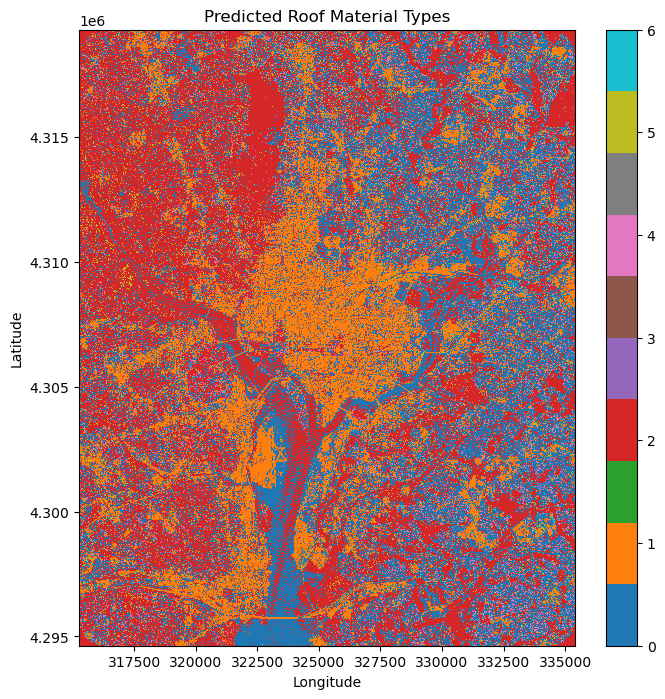

In [34]:
# Plotting the subset
plt.figure(figsize=(8, 8))
preds_da.plot(cmap="tab10", add_colorbar=True, vmin=0, vmax=6)
plt.title("Predicted Roof Material Types")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
# # Export the raster
# out_fp = os.path.join(results_dir, 'dc-xgboost-best_roof_materials_pred.tif')
# preds_da.rio.to_raster(
#     out_img, compress='zstd', zstd_level=9,
#     dtype='uint8', driver='GTiff')

In [41]:
# Mask by building footprints

from rasterio.features import geometry_mask

# Load all MS building footprints (raw)
fp = os.path.join(homedir, 'OPP/training/dc/dc-ms_footprints.gpkg')
footprints = gpd.read_file(fp)

# Create a mask
mask = geometry_mask(
    [geom for geom in footprints.geometry],
    transform=preds_da.rio.transform(),
    invert=True,  # Invert to make buildings True
    out_shape=(preds_da.rio.height, preds_da.rio.width))

# Apply the mask
preds_masked = preds_da.where(mask)

# Export the raster
out_fp = os.path.join(results_dir, 'dc-xgboost-best_roof_materials_pred_mask.tif')
preds_da.rio.to_raster(
    out_fp, compress='zstd', zstd_level=9,
    dtype='uint8', driver='GTiff')

print(f"Successfully exported to {out_fp}!")

Successfully exported to /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/classification/dc-xgboost-best_roof_materials_pred_mask.tif!


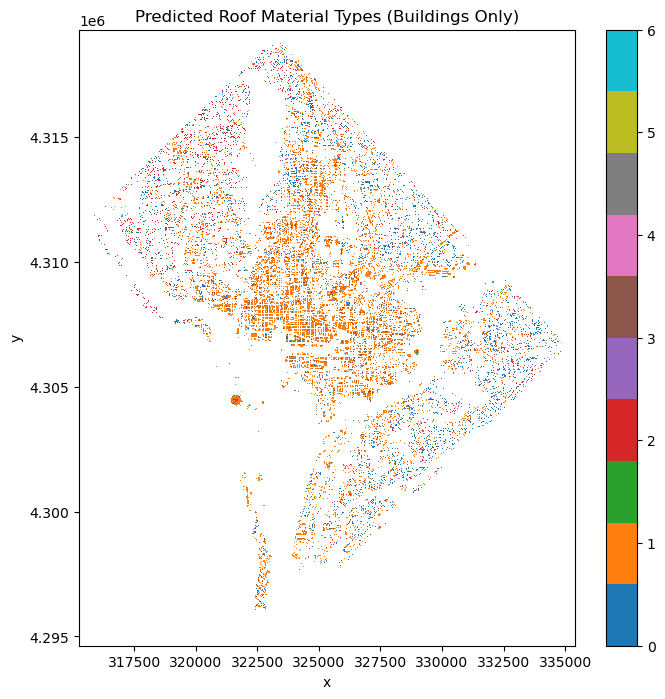

In [42]:
plt.figure(figsize=(8, 8))
preds_masked.plot(cmap="tab10", add_colorbar=True)
plt.title("Predicted Roof Material Types (Buildings Only)")
plt.show()